## Homework 8

## <em> Interpolation, Resampling Methods, and Gaussian Processes</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

### Imports

In [1]:
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='ticks')

### Mounting Google Drive locally
Mount your Google Drive on your runtime using an authorization code.

Note: When using the 'Mount Drive' button in the file browser, no authentication codes are necessary for notebooks that have only been edited by the current user.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
localpath = '/Users/elizabeth/Library/CloudStorage/GoogleDrive-elizabeth.donoway@gmail.com/.shortcut-targets-by-id/1N7VNzEhLpxeYFHjRpWdzVH2k_ZEUEjV6/P188_288/P188_288_HW8/'
colabpath = '/content/drive/My Drive/P188_288/P188_288_HW8/'

***

#### Problem 1 - Back to Quasar (Continued from HW6 - Problem 2 - Part 7)



In [ ]:
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load data
wavelength = np.loadtxt(localpath+"HW5_Problem2_wavelength_300.txt")
X = np.loadtxt(localpath+"HW5_Problem2_QSOspectra_300.txt")
ivar = np.loadtxt(localpath+"HW5_Problem2_ivar_flux_300.txt")

<br><br>
The following analysis is based on https://arxiv.org/pdf/1605.04460.pdf.
<br><br>
In HW6, we reconstruct the QSO spectra from the noisy data. This reconstructed spectra is closer to the true spectra of QSO. Note that in reality, the true spectra can never be directly observed, both due to measurement error and due to absorption by intervening matter along the line of sight. So we wish to perform inference about the true spectra of QSO using a non-parametric technique called <b>Gaussian processes (GP)</b>. We henceforth call the measured spectra as $y(\lambda)$ and the true spectra as $f(\lambda)$ (where $\lambda$ refers to wavelength).
<br><br>
A gaussian process is fully specified by its first two central moments: a mean function $\mu(\lambda)$ and a covariance function $K(\lambda, \lambda')$: <br><br>
$$ \mu(\lambda) = \mathbb{E}[f(\lambda)\ \vert\ \lambda] $$<br>
$$ K(\lambda, \lambda') = \mathrm{cov}[f(\lambda), f(\lambda')\ \vert\ \lambda, \lambda']. $$
<br>
In this problem, we can derive the posterior distribution of $f$ conditioned on the observed values of $y$: <br><br>
$$ p(f^*\ \vert\ \lambda^*, \lambda, y, \sigma(\lambda)^2) = \mathcal{N}(f^*\ \vert\ \mu_{f|y}(\lambda^*), K_{f|y}(\lambda^*, \lambda^{*,})) $$
<br>
where $\mathcal{N}(f\ \vert\ \mu, K)$ is a multivariate Gaussian given by: <br>
$$ \mathcal{N}(f\ \vert\ \mu, K) = \frac{1}{\sqrt{(2\pi)^d \mathrm{det}K}} \mathrm{exp}\big(-\frac{1}{2}(f-\mu)^TK^{-1}(f-\mu)\big) $$<br>
where $d$ is the dimension of $f$.
<br><br><br><br>
In other words, for the QSO $i$, the measured spectra $y$ is $X_{row\ i}$. Then, we can compute the posterior distribution of $f$ given $X_{row\ i}$ as:
<br><br>
$$ \mathcal{N}\big(f\ \big\vert\ \mu_{f|X_{row\ i}}, K_{f|X_{row\ i}}\big) $$
<br>
where $\mu$ is given by:

<br><br>
$\mu = 
\begin{bmatrix}
    \overline{x}_1 & \overline{x}_2 & \dots  &  \overline{x}_{824} \\
\end{bmatrix}.$
<br><br>

The mean function $\mu_{f|X_{row\ i}}$ and the covariance function $K_{f|X_{row\ i}}$ are defined as:<br><br>
$$ \mu_{f|X_{row\ i}} = \mu\ +\ K(K + V)^{-1}(X_{row\ i} - \mu)  $$<br>
$$ K_{f|X_{row\ i}} = K - K(K + V)^{-1}K$$
<br>
where $K = \phi \phi^T$ (We can use $\phi$ from HW7, Problem 2, Part 7. $\phi$ is a matrix of eigenvectors, its dimension is "nLambda" x "nEigvec"). <br><br>$V$ is a diagonal matrix whose entries are $\sigma(\lambda)^2$ e.g. for the QSO $i$, $V$ = np.diag(1/ivar[i,:]).
<br><br>
Finally, we can plot $f(\lambda)$ by sampling from $\mathcal{N}\big(f\ \big\vert\ \mu_{f|X_{row\ i}}, K_{f|X_{row\ i}}\big)$.
<br><br>
We will first provide you with working EMPCA code that will generate the eigenspectrum matrix $\phi$ for 10 eigenspectra ("nEigvec" = 10). This is given below:

In [4]:
# CREATION OF PHI

# Create an aray of random orthonormal vectors
# Reference: https://github.com/sbailey/empca
def _random_orthonormal(nvec, nvar, seed=1):
    """
    Return array of random orthonormal vectors A[nvec, nvar] 
    Doesn't protect against rare duplicate vectors leading to 0s
    """

    if seed is not None:
        np.random.seed(seed)
        
    A = np.random.normal(size=(nvec, nvar))
    for i in range(nvec):
        A[i] /= np.linalg.norm(A[i])

    for i in range(1, nvec):
        for j in range(0, i):
            A[i] -= np.dot(A[j], A[i]) * A[j]
            A[i] /= np.linalg.norm(A[i])

    return A

# Number of quasars
nQSO = len(X)
# Number of wavelength bins
nLambda = len(wavelength)
# Number of eigenvectors we want
nEigvec = 10

# A set of random orthonormal vectors
phi = _random_orthonormal(nLambda, nEigvec, seed=1)

# Solve Ax = b with weights w using the above set of equations
# Reference: https://github.com/sbailey/empca
import scipy
def _solve(A, b, w):
    """
    Solve Ax = b with weights w; return x
    
    A : 2D array
    b : 1D array length A.shape[0]
    w : 1D array same length as b
    """
  
    #- Apply weights
    # nvar = len(w)
    # W = dia_matrix((w, 0), shape=(nvar, nvar))
    # bx = A.T.dot( W.dot(b) )
    # Ax = A.T.dot( W.dot(A) )
    
    b = A.T.dot( w*b )
    A = A.T.dot( (A.T * w).T )
    if isinstance(A, scipy.sparse.spmatrix):
        x = scipy.sparse.linalg.spsolve(A, b)
    else:
        x = np.linalg.lstsq(A, b)[0]
        
    return x


C = np.zeros( (nEigvec, nQSO) )

W = ivar

# Number of iterations for EMPCA
niteration = 20

for jj in range(niteration):
    print("iteration", jj+1, "/20")
    
    # E-step
    for i in range(nQSO):
        b = X[i,:]
        A = phi  
        w = W[i,:]           
        C[:,i] = _solve(A, b, w) 

    # M-step
    for j in range(nLambda):
        b = X[:,j]
        A = C.T
        w = W[:,j]
        phi[j,:] = _solve(A, b, w)

iteration 1 /20
iteration 2 /20


/var/folders/t8/7g7jdx3n3k922dx6x9y00dd40000gp/T/ipykernel_4583/1859123926.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


iteration 3 /20
iteration 4 /20
iteration 5 /20
iteration 6 /20
iteration 7 /20
iteration 8 /20
iteration 9 /20
iteration 10 /20
iteration 11 /20
iteration 12 /20
iteration 13 /20
iteration 14 /20
iteration 15 /20
iteration 16 /20
iteration 17 /20
iteration 18 /20
iteration 19 /20
iteration 20 /20


<span style="color:blue"> <i> 1. For spectra with indices 100 and 300, plot $f(\lambda)$ using a Gaussian process. You can use np.random.multivariate_normal (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.multivariate_normal.html) to sample from a multivariate Gaussian. Plot the original spectra in the same figure for comparison. </i></span> <br>

In [5]:
# Compute Gaussian Processes
mu = np.mean(X, axis=0)
K = phi @ phi.T
V = lambda i: np.diag(1/ivar[i,:])

def mu_f(row):
    return mu + K @ np.linalg.inv(K + V(row)) @ (X[row] - mu)

def K_f(row):
    return K - K @ np.linalg.inv(K + V(row)) @ K

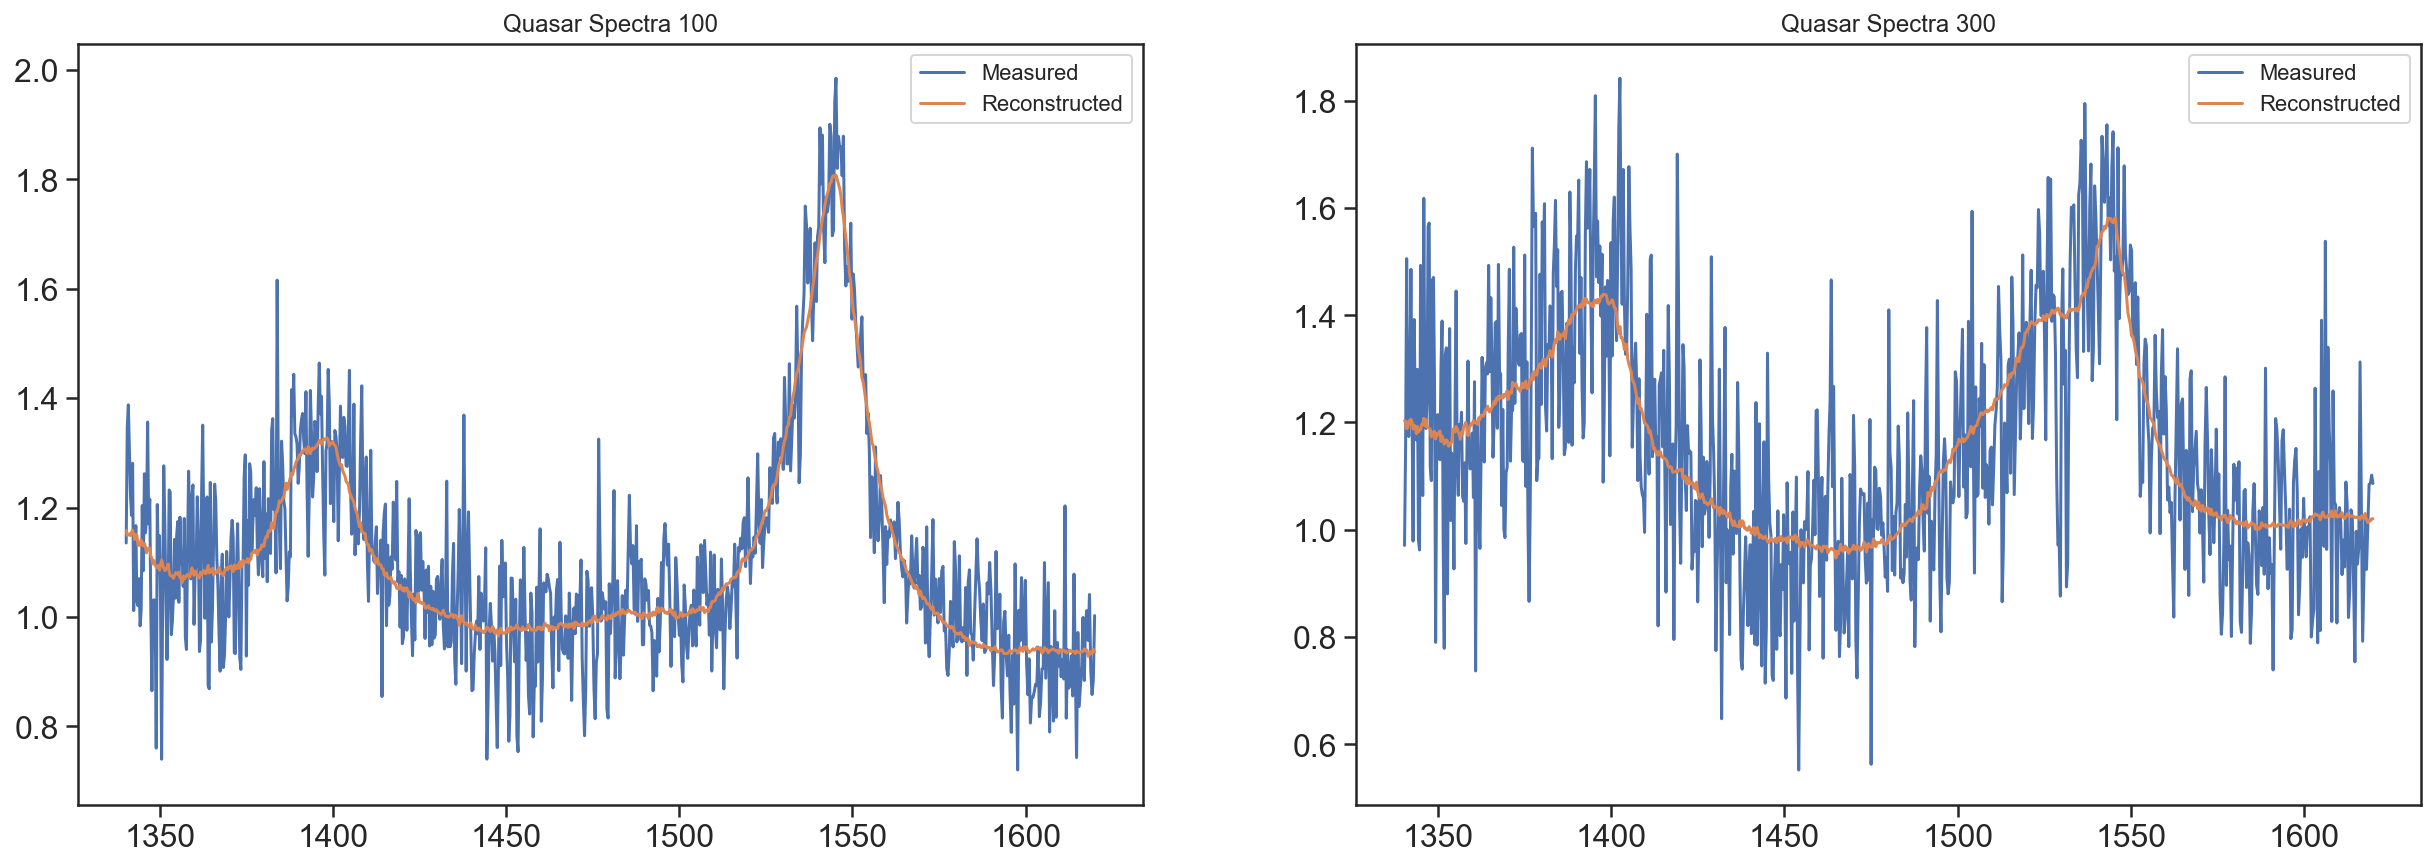

In [16]:
qso=100
ax1 = plt.subplot(121)
ax1.plot(wavelength, X[qso], label='Measured')
ax1.plot(wavelength, np.random.multivariate_normal(mu_f(qso), K_f(qso)), label='Reconstructed')
ax1.set_title(f'Quasar Spectra {qso}')
ax1.legend()
qso=300
ax2 = plt.subplot(122)
ax2.plot(wavelength, X[qso], label='Measured')
ax2.plot(wavelength, np.random.multivariate_normal(mu_f(qso), K_f(qso)), label='Reconstructed')
ax2.set_title(f'Quasar Spectra {qso}')
ax2.legend()
plt.show()

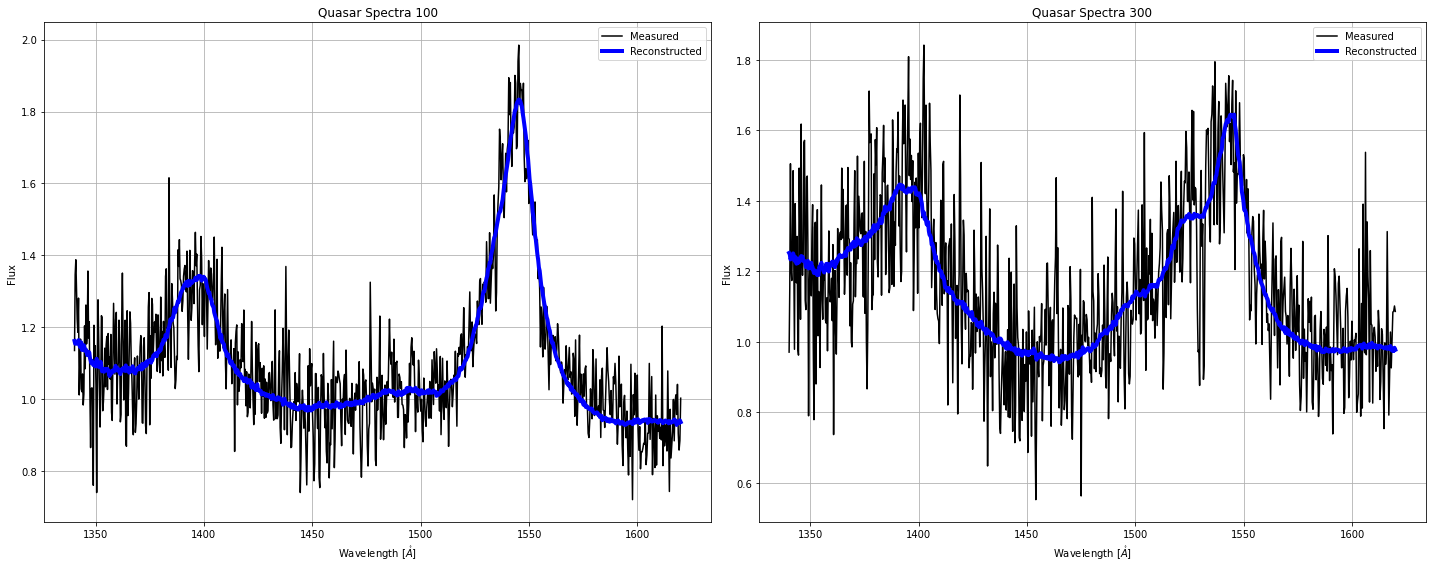

In [ ]:
# Plot GP for QSOs 100 and 300, compare with original measured spectra

### Problem 2: Optimization with Gaussian Processes

In the previous problem, we used Gaussian Processes (GPs) to effectively smooth data. GPs have many other applications, one of the most important of which is optimization of extremely generic functions (here we'll always talk about maximization). We'll focus on GP-assisted optimization in this problem.

The gradient-based optimization methods we covered in class do not work when applied to multi-modal, non-convex, or noisy functions, as the gradient will be unreliable. Also, in real life, evaluating the function in question might also be very expensive - so we can't just dump a bunch of points down and check which is biggest.
One way around this problem is to use a cheap *surrogate model* $s(x)$ that approximates the target function $f(x)$. GPs provide this surrogate model through their mean $\mu(x)$, which interpolates the points given by the data.

In [17]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular as tri_solve

The core of Bayesian Optimization is weighing exploration and exploitation in choosing new points to evaluate - this is encapsulated in the *Acquisition Function* (AF), which heuristically is:

$AF(x) = \rm{target}(x) +  \rm{uncertainty}(x)$

i.e. we want to be greedy (exploit) when we find a region of high value of the target $f$ and look around locally for more high-value points. 
At the same time, we want to occasionally look in regions that we haven't already seen yet - we don't want to e.g. miss a peak of a bimodal distribution.

Since our function $f(x)$ might be expensive, we can't use it as the target (since we need to evaluate the AF many times), so instead we use an approximate *surrogate model* $s(x)$ as a stand in for $f(x).$

One of the simplest AFs is *Upper Confidence Bound* (or UCB):

${\rm UCB}(\theta) = \mu(\theta) + \beta_{\rm UCB}\sigma(\theta)$

where $\mu(\theta)$ is the GP mean and $\sigma(\theta)$ is its variance.
For simplicity, we will take $\beta_{\rm UCB}=1$.
By just adding the GP mean and its uncertainty estimate, this very simple AF clearly combines both exploration and exploitation.

*Below is some example code that performs Bayesian optimization on a 1D nonconvex objective using UCB.* We include a class that computes the mean and uncertainty for a Gaussian process with a fixed kernel.

In this case, we are using the kernel

$$k(x_i, x_j)=\sigma_k^2 \exp\left(\frac{-|x_i-x_j|^2}{2L}\right)$$

with $L=1, \sigma_k^2=5$ (We'll optimize these hyperparameters in Part 3). Recall from lecture that the mean and uncertainty on the model at a predicted point $x_*$ are given by

$$\mu(x_*)=k(x_*, \vec{X})^T(K + \sigma^2 I)^{-1}y$$

and

$$\sigma^2(x_*) = k(x_*, x_*) - k(x_*, \vec{X})^T (K + \sigma^2 I)^{-1} k(x_*, \vec{X}),$$

where $K_{ij} = k(x_i, x_j)$, $\vec{X}$ is the input vector (components $X_i = x_i$ are each measurement), $I$ is the identity matrix, and $\sigma$ is the uncertainty in each measurement (not to be confused with the GP uncertainty prediction $\sigma^2(x_*)$), which will be set to zero in this case. The code evaluates $\sigma^2(x_*)$ by performing a Cholesky decomposition $(K + \sigma^2 I) = L L^T$ or equivalently, $(K + \sigma^2 I)^{-1} = (L^T)^{-1} L^{-1}$.

(Note: The $\sigma^2(x_*)$ differs from the one shown in the lecture by $\sigma^2$ because this is uncertainty in the model, and the lecture shows uncertainty on future measurements, which adds the measurement uncertainty $\sigma$ in quadrature.)

In [18]:
# Construct the GP (we'll use a squared-exponential kernel with fixed length scale L and amplitude sigmaksq)
def squared_exp(x1,x2,L): return np.exp(  -np.sum( (x1-x2)**2 )/(2*L)  )

class gp:
    ''''A simple GP class with mean and uncertainty functions for a given set of data X, Y'''
    def __init__(self,X,Y,L=1,sigmaksq=5,noise=0):
        self.X,self.Y,self.L,self.sigmaksq = X,Y,L,sigmaksq #L,sigmaksq are the kernel lengthscale and amplitude hyperparameters
        self.noise = noise # our guess at the input noise sigma^2
        self.N = self.X.shape[0]
        self.kernel = lambda x1,x2: self.sigmaksq*squared_exp(x1,x2,self.L)
        self._build_matrix()
    
    def _build_matrix(self):
        self.K = np.zeros((self.N,self.N))
        for i in range(self.N): 
            for j in range(i,self.N): 
                self.K[i,j] = self.kernel(self.X[i],self.X[j])
                self.K[j,i] = self.K[i,j]
        self.k = lambda x: np.array([self.kernel(x,self.X[i]) for i in range(self.N)])
        
        self.L_K = scipy.linalg.cholesky(self.K+self.noise*np.eye(self.N)) #(K+sigma^2I) = L LT -> (K+sigma^2I)^-1 = LT^-1 L^-1
        # L_K is the L in the cholesky decompostition L L^T of (K+sigma^2I)^-1
        
        #triangular solve for mean
        self.inv_Ky = tri_solve( self.L_K,tri_solve(self.L_K.T,self.Y,lower=True) ) # use above but obtain L^-1 via tri solve
        # inv_Ky is [(K+sigma^2I)^-1]y
    
    def mu(self,x):
        return np.dot(self.k(x),self.inv_Ky.T) # k.T (K + sigma^2I)^-1 y
        
    def sigma(self,x):
        v = tri_solve(self.L_K.T,self.k(x),lower=True) #L^-1 k
        return np.sqrt(self.kernel(x,x) - np.dot(v,v) + self.noise) # np.sqrt( k(x,x) - k(x)^T (K + sigma^2 I)^-1 k(x) + sigma^2 ) 
# Write UCB AF
def AF_UCB(x,gp): return gp.mu(x) + gp.sigma(x)


In [119]:
#1D SineCosine target function [defined on [0,10]], generate 3 data points from this
def sc(x): return 10.3368 - x*( np.sin(x)+np.cos(2*x) )
np.random.seed(42) # keep this in order to use the same fit points
xx = np.linspace(0,10,100)
X = np.random.uniform(0,10,size=3)
Y = sc(X) #+ np.random.randn(len(X)) #Here we will do the noiseless case, but you could use noisy data by uncommenting

Now let's look at a GP fit to our three data points before doing any optimization to get an idea of what is going on.

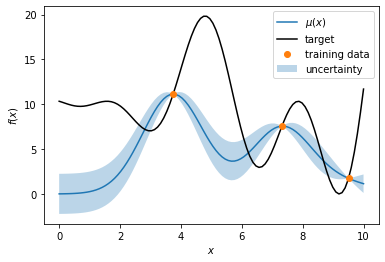

In [ ]:
st = gp(X,Y,sigmaksq=5) #get the GP
# Get the GP mean and uncertainties (NB the input to these functions must be single x values, not arrays)
mus=np.array([st.mu(xi) for xi in xx])
sigmas=np.array([st.sigma(xi) for xi in xx])
plt.plot(xx,mus,label=r'$\mu(x)$')
plt.plot(xx,sc(xx),c='k',label="target")
plt.fill_between(xx,mus-sigmas,mus+sigmas,alpha=0.3,label='uncertainty')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.plot(X, Y, ls='',marker='o',label='training data')
plt.legend(prop={"size":10})

Visualizing the UCB AF below, we see that the function prefers points that have a high surrogate value (where orange is high) and where we haven't explored (where uncertainty, green, is high).

Text(0.5, 0, '$x$')

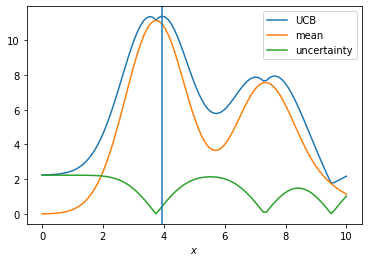

In [ ]:
plt.plot(xx,[AF_UCB(xi,st) for xi in xx],label='UCB')
plt.plot(xx,[st.mu(xi) for xi in xx],label='mean')
plt.plot(xx,[st.sigma(xi) for xi in xx],label='uncertainty')
plt.axvline(xx[np.argmax([AF_UCB(xi,st) for xi in xx])])
plt.legend()
plt.xlabel(r'$x$')


Clearly the GP interpolates the points and becomes more uncertain (wider bands) between them. Right now our inital points (orange) are pretty far from the maximum (which is around $x=5$) so we will run Bayesian Optimization to get closer without getting stuck in a false maximum.

In [121]:
#Simple optimization routine
def BO_1d(X,Y,N_budget,f=sc,x_min=0.,x_max=10.,N_cand=100):
    for i in range(1,N_budget):
        # Fit the GP
        s = gp(X,Y,L=1,sigmaksq=5,noise=1e-6) #we add a very small amount of noise for numerical purposes
        # Evaluate the AF
        x_cand = np.linspace(x_min,x_max,N_cand)
        AF_vals = [AF_UCB(x_cand[i],s) for i in range(N_cand)]
        # Select the next point from some candidates
        x_next = x_cand[np.argmax(AF_vals)]
        y_next = f(x_next)
        X,Y = np.append(X,x_next),np.append(Y,y_next)
    s = gp(X,Y,L=1,sigmaksq=5,noise=1e-6)
    x_opt = X[np.argmax(Y)]
    return x_opt,s

In [122]:
x_best, gp_bo_1d = BO_1d(X,Y,5) # run optimization for 5 rounds

Now let's plot up our results, as well as the GP surrogate model we learned.

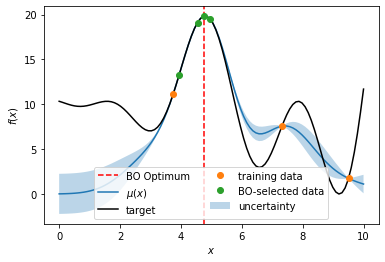

In [ ]:
mus_bo_1d, sigmas_bo_1d = np.array([gp_bo_1d.mu(xi) for xi in xx]),np.array([gp_bo_1d.sigma(xi) for xi in xx])
plt.axvline(x_best,c='r',ls='--',label='BO Optimum')
plt.plot(xx,mus_bo_1d,label=r'$\mu(x)$')
plt.plot(xx,sc(xx),c='k',label="target")
plt.fill_between(xx,mus_bo_1d-sigmas_bo_1d,mus_bo_1d+sigmas_bo_1d,alpha=0.3,label='uncertainty')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.plot(gp_bo_1d.X[:3],gp_bo_1d.Y[:3],c='C1',ls=' ',marker='o',label='training data')
plt.plot(gp_bo_1d.X[3:],gp_bo_1d.Y[3:],c='C2',ls=' ',marker='o',label='BO-selected data')

plt.legend(prop={"size":10},ncol=2)

### Deterministic Langevin Optimization - an alternative method

GPs provide both a surrogate function (the mean $\mu(x)$) and an uncertainty ($\sigma(x)$). But why do we think we can trust this uncertainty? 

The uncertainty given by the GP is significantly affected by the hyperparameters $L$ and $\sigma_{k}^{2}$ that we fixed in our simple optimization runs above. 

One alternative strategy is to use the uncertainty obtained by density estimation. Density estimation, an unsupervised learning task, tells us where we have many data points and where we have few data points through a density $q(x)$. We can then modify our AF such that instead of rewarding places where GP uncertainty is high, we penalize places where the density estimate $q(x)$ is high:

$AF(x) = s(x) - \log q(x)$.

For reasons we don't have time to get into here, this algorithm is called Deterministic Langevin Optimization (DLO). In this part of the problem, we'll use DLO to solve the same problem we looked at above.

The DLO algorithm can be performed using Normalizing Flows (NFs) as the density estimate, which is the preferred choice for high-dimensional target functions due to the curse of dimensionality. However, in this 1d context, we will simply use a Gaussian Kernel Density Estimate (KDE) for $q(x)$, as it demonstrates the qualitative features of the DLO algorithm.

We can get our estimate of q(x) for this problem by using the line

q = gkde(X, bw_method='scott')

if we set X to be the input data vector. This will return a function which can be called at any point x. Regions with higher more points will have higher q, and will therefore be penalized by our AF, as we care to search high and/or unexplored regions.

In [20]:
from scipy.stats import gaussian_kde as gkde

<span style="color:blue"> <i> 1. Using the Bayesian Optimization code above as a model, build the DLO algorithm by modifying the acquistion function and fitting the density estimate $q(x)$. Then make a plot similar to the one above that shows the points DLO evaluates and the optimum, but instead of showing GP uncertainty bands, show the density estimate $q(x)$ instead (you will need to scale it by ~100 to make it show up nicely on the plot).  </i></span> <br>

In [25]:
#Your code here:
def AF_DLO(x,gp,q): 
    return gp.mu(x) - np.log(q(x))

def DLO_1d(X,Y,N_budget,f=sc,x_min=0.,x_max=10.,N_cand=100):
    for i in range(1,N_budget):
        # Fit the GP
        s = gp(X,Y,L=1,sigmaksq=5,noise=1e-6) #we add a very small amount of noise to avoid inverting singular matrices
        q = gkde(X, bw_method='scott')
        # Evaluate the AF at N_cand candidate positions
        x_cand = np.linspace(x_min,x_max,N_cand) # use a uniformly spaced array
        AF_vals = [AF_DLO(x_cand[i],s,q) for i in range(N_cand)]
        # Select the next point from some candidates
        x_next = x_cand[np.argmax(AF_vals)]
        y_next = f(x_next)
        # Append these points to the data
        X,Y = np.append(X,x_next),np.append(Y,y_next)
    s = gp(X,Y,L=1,sigmaksq=5,noise=1e-6)
    q = gkde(X, bw_method='scott')
    x_opt = X[np.argmax(Y)]
    return x_opt,s,q

In [36]:
x_best_dlo, gp_dlo_1d, q_dlo_1d = DLO_1d(X,Y,5) # run optimization for 5 rounds

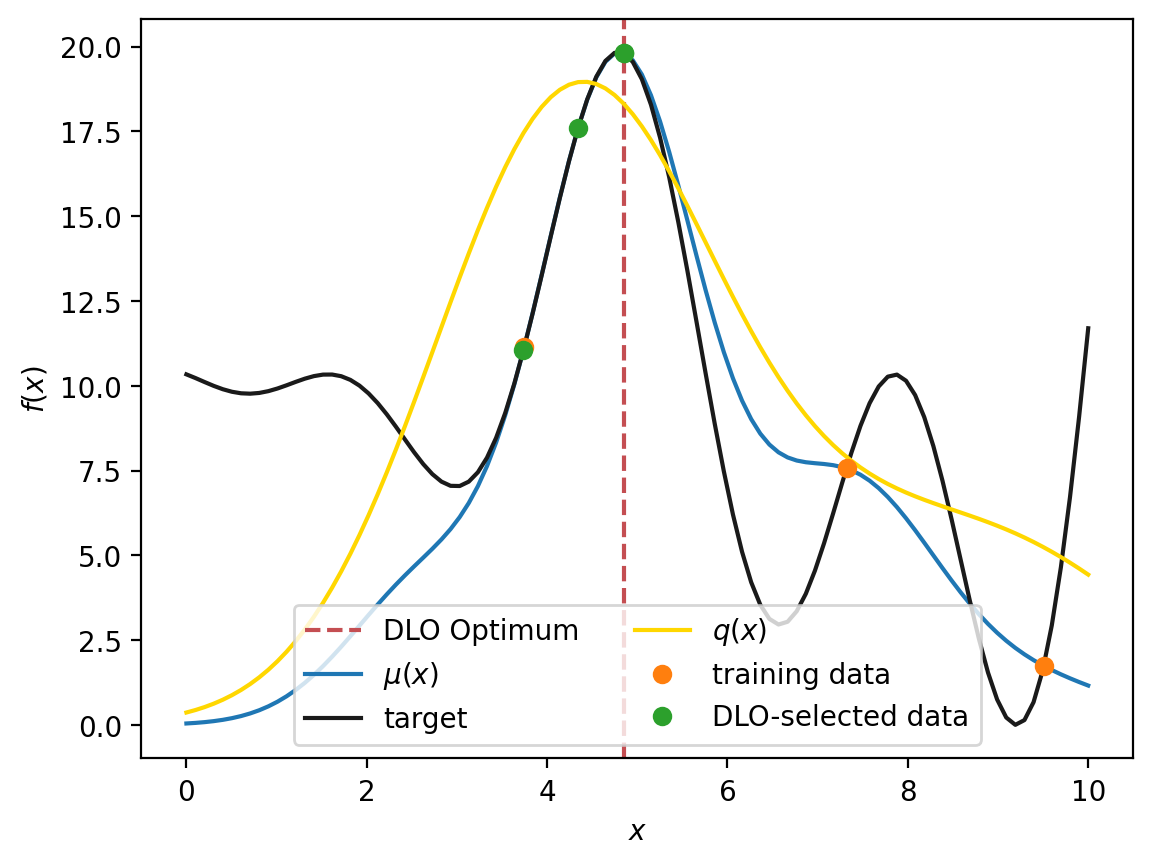

In [53]:
#Your plotting code here:
mus_dlo_1d, sigmas_dlo_1d = np.array([gp_dlo_1d.mu(xi) for xi in xx]),np.array([gp_dlo_1d.sigma(xi) for xi in xx])
plt.axvline(x_best_dlo,c='r',ls='--',label='DLO Optimum')
plt.plot(xx,mus_dlo_1d,label=r'$\mu(x)$')
plt.plot(xx,sc(xx),c='k',label="target")
plt.plot(xx,100*q_dlo_1d(xx),c='gold',label="$q(x)$")
# plt.fill_between(xx,mus_dlo_1d-sigmas_dlo_1d,mus_dlo_1d+sigmas_dlo_1d,alpha=0.3,label='uncertainty')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.plot(gp_dlo_1d.X[:3],gp_dlo_1d.Y[:3],c='C1',ls=' ',marker='o',label='training data')
plt.plot(gp_dlo_1d.X[3:],gp_dlo_1d.Y[3:],c='C2',ls=' ',marker='o',label='DLO-selected data')

plt.legend(prop={"size":10},ncol=2)

Now let's try this on the 10-D Rosenbrock function!

The Rosenbrock function is a nonconvex function with a long curving degeneracy. This often arises in practice during Bayesian inference when posteriors involve models with nonlinear dependencies between parameters - there it is usually called the "banana". 
This banana is particularly nasty since it is very thin - which makes it challenging for any optimization algorithm.
We will show that DLO outperforms the gradient-based BFGS in the limit of a low number of samples. First, here is the code that evaluates this function (we call it banana because it looks like one in 2-D)

In [55]:
def banana(x):
    #from https://arxiv.org/pdf/1506.00171.pdf, for [-5,5]^d, opt at (1,1,...)
    a, b = 1., 100.
    d = x.shape[-1]
    f = np.sum( (a-x[:-1])**2 + b*(x[1:]-x[:-1]**2)**2, axis=-1 )
    xmax = np.ones(d)*-5. #WARNING THIS ONLY WORKS FOR THESE BOUNDS!
    fmax = np.sum( (a-xmax[:-1])**2 + b*(xmax[1:]-xmax[:-1]**2)**2, axis=-1    ) +1e-5 #little kick so we don't get an exact zero...
    return np.log(fmax-f)

The two-dimensional version looks like this:

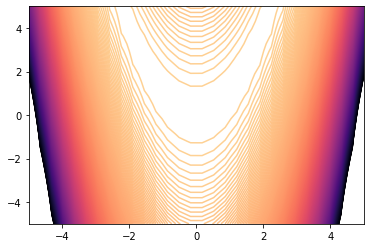

In [ ]:
x = np.linspace(-5., 5., 30)
y = np.linspace(-5., 5., 30)
X, Y = np.meshgrid(x, y)
ros2d = lambda x,y: banana(np.concatenate([[x],[y]]))
rosarr = np.zeros((30,30))
for i in range(30): 
    for j in range(30): 
        rosarr[i,j] = ros2d(X[i,j],Y[i,j])
fig = plt.figure()
ax = plt.axes()#projection='2d')
ax.contour(X, Y, rosarr,levels=np.logspace(np.log10(10.5),np.log10(11.5),500), cmap='magma',)
                       #linewidth=0, antialiased=False)
# ax.view_init(55, 30)
plt.show()


In higher dimensions, finding the global maximum of this function becomes extremely challenging to find efficiently, even with gradient-based methods, as there are no nice theoretical guarantees for the nonconvex case.

In this problem, we will optimize this function in 10 dimensions - first, using a similar stragety to above with our simplified DLO, and second, using a gradient-based method we covered previously (BFGS).

We will use the very simple gp code from above that generalizes to n-dimensions that you can use in this problem:


In [57]:
# Set number of dimensions for the Rosenbrock function to 10
d=10

In high dimensions we can no longer throw down candidate points across the whole volume of the domain we are considering - the curse of dimensionality means a fixed number of these points are much less useful as $d$ increases.
Now that we are in $10d$, we need to search progressively smaller regions as our optimization procedes so that our candidate points fed into the AF cover a smaller volume.

For each iteration, you should create a box of side length $10V$ centered on the best value found so far. Then you should choose N_cand points randomly using np.random.uniform in that box.

**V must be some monotonically decreasing function that scales the volume down as the number of iterations goes up** - we choose:

$$V = 1/\sqrt{i}$$

for iteration $i$.
This is enough to beat BFGS here, but for very multimodal functions, the best choice of volume shrinkage is not actually monotonic - you don't want to get trapped in local maxima!

Make sure to check your candidate points are not going out of bounds!

We will also provide BFGS code for comparison purposes, run this cell to generate arrays of evaluation number and best value found after corresponding numbers of evaluations:

In [93]:
#some code to run bfgs at fixed budget
def run_bfgs(f,bounds,d,GLOBAL_BUDGET=None, random_seed=0,x0=None):
    if(GLOBAL_BUDGET is None): GLOBAL_BUDGET=10+5*d
    bounds = np.array(bounds).T
    np.random.seed(random_seed)
    x0 = np.random.uniform(bounds[:,0],bounds[:,1]) if x0 is None else x0
    bfgs = scipy.optimize.minimize(f, bounds=bounds,
                                   method='BFGS',x0=x0,
                      options={'return_all':True,'maxiter':(GLOBAL_BUDGET-1)//(d+1),
                              'ftol':1e-16})
    evals = np.arange(bfgs.nfev+1)[bfgs.nfev//len(bfgs.allvecs)::bfgs.nfev//len(bfgs.allvecs)] # a bit of a hack...
    fmaxhist = np.maximum.accumulate([-f(np.array(bfgs.allvecs)[i]) for i in range(len(bfgs.allvecs))])
    return bfgs.x,-bfgs.fun,evals,fmaxhist

_, _, bfgs_evals, bfgs_fmaxhist = run_bfgs(lambda x: -banana(x), bounds = [[-5. for i in range(d)],[5. for i in range(d)]], d=d)

/Users/elizabeth/opt/miniconda3/envs/phys288/lib/python3.8/site-packages/scipy/optimize/_minimize.py:538: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/var/folders/t8/7g7jdx3n3k922dx6x9y00dd40000gp/T/ipykernel_4583/3727079056.py:7: OptimizeWarning: Unknown solver options: ftol
  bfgs = scipy.optimize.minimize(f, bounds=bounds,


<span style="color:blue"> <i> 2. Build a general n-dimesional version of the DLO algorithm. This should be similar to what was done in Part 1, except it accepts higher dimensional input and chooses candidates in a shrinking box centered on the found maximum as described above. Initialize it with 20 random points in a box of side length 10 centered at the origin. Then compare this against BFGS by plotting the best guess of the optimum of each algorithm as a function of the number of function evaluations performed (make sure to include these initial 20). (np.maximum.accumulate might be useful for finding the maximum value in the first N values of an array) </i></span> <br>

In [89]:
def DLO_nd(X,Y,N_budget,f,d,x_min=-5,x_max=5,N_cand=100):
    np.random.seed(0)
    for i in range(1,N_budget):
        # Fit the GP
        s = gp(X,Y,L=1,sigmaksq=5,noise=1e-6) #we add a very small amount of noise to avoid inverting singular matrices
        q = gkde(X.T, bw_method='scott')
        # Evaluate the AF
        V = 1 / np.sqrt(i) 
        x_min, x_max = x_min*V, x_max*V
        x_cand = [np.random.uniform(x_min, x_max, size=10) for i in range(N_cand)] # center a box on the best value found so far, side length 10V
        AF_vals = [AF_DLO(x_cand[i],s,q) for i in range(N_cand)] # how do we treat the density here?????
        # Select the next point from some candidates
        x_next = x_cand[np.argmax(AF_vals)]
        y_next = f(x_next)
        X,Y = np.vstack([X,x_next[None,:]]),np.append(Y,y_next)
    s = gp(X,Y,L=1,sigmaksq=5,noise=1e-6)
    x_opt = X[np.argmax(Y)]
    x_hist,y_hist = X,Y
    return x_opt,s,x_hist,y_hist

In [101]:
# compute optimization results, storing values after each iteration
X = np.random.uniform(-5,5,size=(20,10))
Y = [banana(X[i]) for i in range(20)]
x_best_dlo_nd, gp_dlo_nd, x_hist_dlo_nd, y_hist_dlo_nd = DLO_nd(X,Y,70,banana,10)

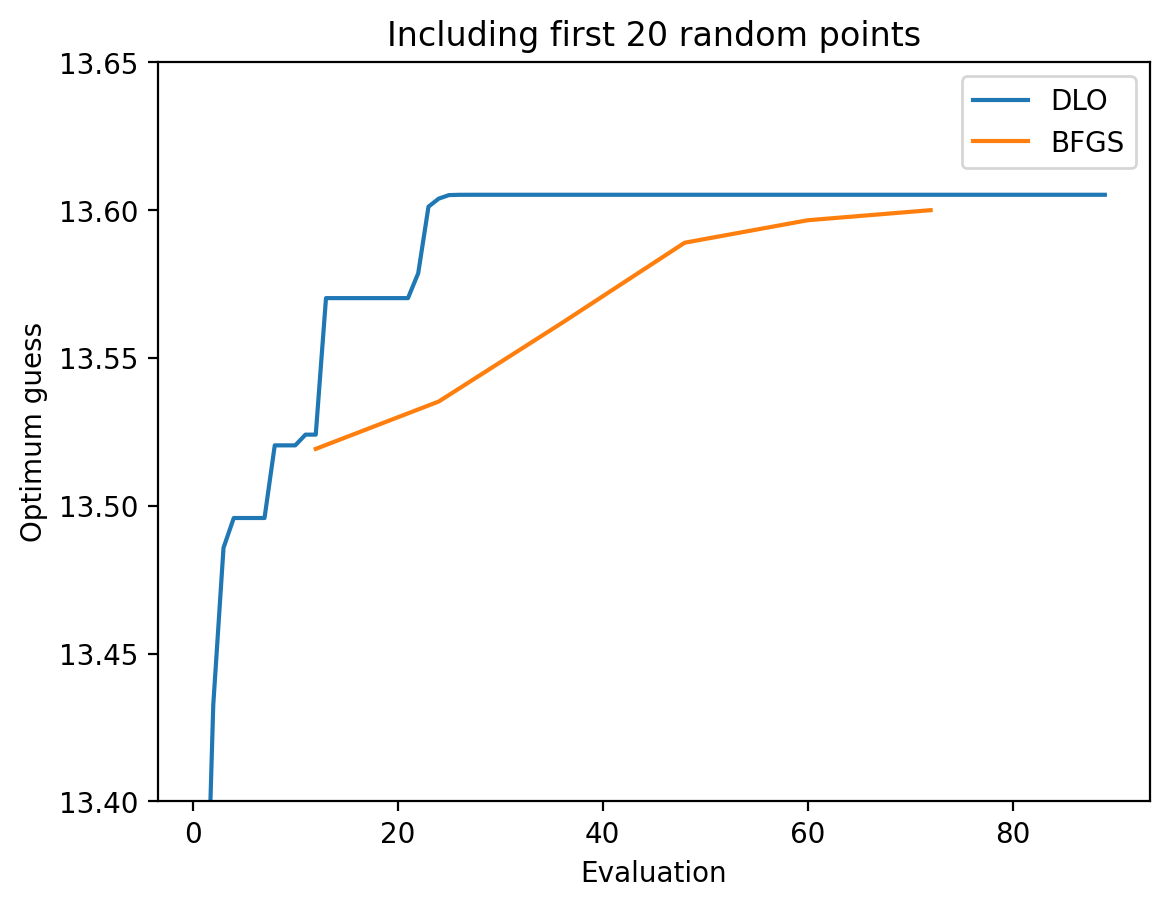

In [156]:
#plot dlo
plt.plot(np.arange(1,len(y_hist_dlo_nd)+1,1), np.maximum.accumulate(y_hist_dlo_nd), label='DLO')
#plot bfgs
plt.plot(bfgs_evals, bfgs_fmaxhist, label='BFGS')
plt.legend()
plt.ylim(13.4,13.65)
plt.ylabel('Optimum guess')
plt.xlabel('Evaluation')
plt.title('Including first 20 random points')
plt.show()

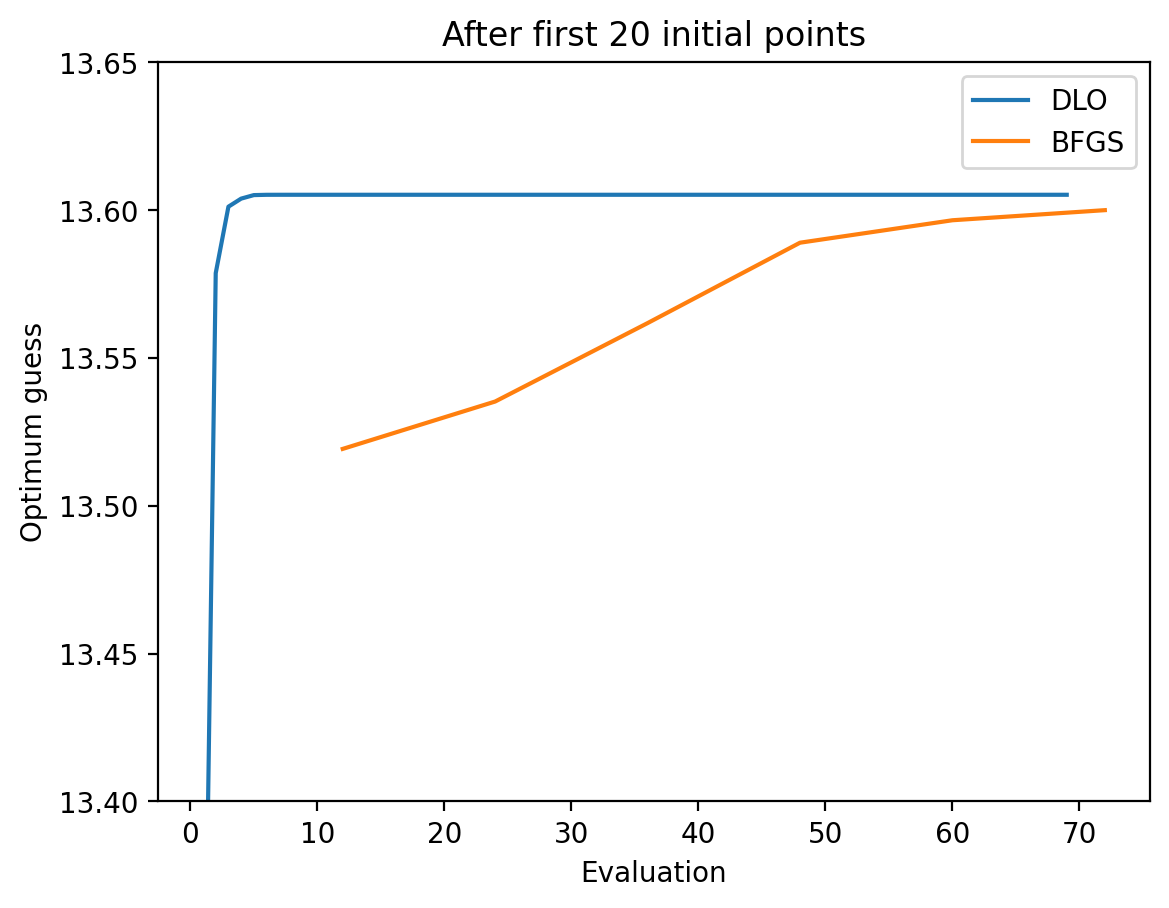

In [155]:
X = np.random.uniform(-5,5,size=(20,10))
#plot dlo
plt.plot(np.arange(1,len(y_hist_dlo_nd)-len(X)+1,1), np.maximum.accumulate(y_hist_dlo_nd[len(X):]), label='DLO')
#plot bfgs
plt.plot(bfgs_evals, bfgs_fmaxhist, label='BFGS')
plt.legend()
plt.ylim(13.4,13.65)
plt.ylabel('Optimum guess')
plt.xlabel('Evaluation')
plt.title('After first 20 initial points')
plt.show()

So far we have totally neglected the fixed hyperparameters in our simple GP implementation. The last major step to connecting to realistic GP-based surrogate optimization is fit the hyperparameters to the data.

Let's go back to our 1d example and modify the GP function.

In the lecture 10 slides, you covered "Learning the Kernel" where the GP marginal likelihood is written down in closed form. We will be maximizing this likelihood with respect to the hyperparameters $L$ and $\sigma_k^2$.

In modern ML applications, this optimization is typically done using automatic differentiation gradients, but here we can use a simple gradient descent algorithm. We provide a gradient descent code for you to use here (please use the given learning rate and stepsize for ease of grading). Important, this code minimizes, and you want to maximize log likelihood, so be sure to minimize minus log likelihood.

In [113]:
def grad_fd(f,x,eps):
    n = len(x) # dimension of input, 2 in this case
    grad = np.zeros(n) # initialize gradient array
    for i in range(n):
        tmp = np.zeros(n)
        tmp[i] = eps # initialize array that is eps only in the given direction
        grad[i] = (f(x+tmp)-f(x-tmp))/(2*eps) # calculate finite difference in the ith direction
    return grad

def grad_descent(f,N,x0,lr=1e-2):
    x=x0 # start at initial value x0
    xhist,fhist=[],[] # initialize arrays of parameters and values of the function at those points
    xhist.append(x0) # start with initial point
    fhist.append(f(x0)) # start with function value at initial point
    for i in range(N):
        x = x - lr*grad_fd(f,x,1e-3) # subtract learning rate times gradient (gradient descent)
        xhist.append(x) # append next point
        fhist.append(f(x)) # append function value at next point
    return x,xhist,fhist

<span style="color:blue"> <i> 3. First define the marginal log likelihood. Then, using the data in the variable gp_bo_1d defined above Part 1, and beginning at the values $L=1, \sigma_k^2=5$ from Part 1, run this optimization for enough iterations n_iter such that you converge within 0.1 in marginal log likelihood. State the optimal hyperparameters that you find and the number of steps required to reach within the stated tolerance. Are the optimized parameters close to the starting values? </i></span> <br>

In [124]:
def marginal_log_likelihood(X,Y,x0,noise=1e-6):
    L, sigmaksq = x0[0], x0[1]
    s = gp(X,Y,L,sigmaksq,noise)
    return -0.5*np.log(np.linalg.det(s.K)) - 0.5*s.Y @ s.inv_Ky

minus_ll = lambda x0: -marginal_log_likelihood(gp_bo_1d.X,gp_bo_1d.Y,x0)

In [151]:
params_best, param_hist, ll_hist = grad_descent(minus_ll,200,np.array([1,5]))
ll_hist1 = np.append(ll_hist,0)
ll_hist2 = np.append(0,ll_hist)
n_conv = np.argwhere(np.abs(ll_hist1-ll_hist2)<=0.1)[0,0]
print('Optimal hyperparameters:')
print('L =', np.array(param_hist[n_conv][0]), ', sigmaksq =', np.array(param_hist[n_conv][1]))
print('Number of iterations to convergence within tolerance:', n_conv)

Optimal hyperparameters:
L = 0.8627191240761469 , sigmaksq = 8.04087200248146
Number of iterations to convergence within tolerance: 63


The optimized parameters are somewhat close to the starting values. $L_{opt} \approx 0.8627$ is fairly close to $L_{ini}=1$, and $\sigma_k^2 \approx 8.0409$ is a bit further from the starting value $\sigma_k^2 = 5$. 